In [2]:
!pip install pennylane


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.7 MB/s eta 0:00:00


### 1. Importing Libraries

In [ ]:
# Import required libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import pennylane as qml

## 2. Neural network model for classical PINN

In [ ]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

### Define the quantum device

In [ ]:
n_qubits = 4
dev = qml.device('default.qubit', wires=n_qubits)

### Define the quantum circuit for QPINN

In [ ]:
# Define the quantum circuit for QPINN
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

###  Neural network model for QPINN

In [ ]:
# Neural network model for QPINN
class QPINN(nn.Module):
    def __init__(self):
        super(QPINN, self).__init__()
        self.fc1 = nn.Linear(1, n_qubits)  # Input to qubits
        self.q_params = nn.Parameter(torch.randn(2, n_qubits, 3, dtype=torch.float32))  # Quantum circuit parameters
        self.fc2 = nn.Linear(n_qubits, 1)  # Qubits to output

    def forward(self, x):
        x = self.fc1(x)
        q_out = torch.stack([torch.tensor(quantum_circuit(xi, self.q_params), dtype=torch.float32) for xi in x])  # Compute quantum circuit for each input and convert to tensor
        x = self.fc2(q_out)
        return x

### Generate synthetic data for rain-runoff model

In [ ]:
# Generate synthetic data for rain-runoff model
time_steps = np.linspace(0, 100, 101)
precipitation = np.random.uniform(0, 10, len(time_steps))
soil_moisture = np.zeros_like(time_steps)

### Initial conditions and parameters

In [ ]:
# Initial conditions and parameters
soil_moisture[0] = 30.0
ET = 1.0
S_threshold = 50.0
c = 0.5
n = 2.0

###Simulate soil moisture over time

In [ ]:
# Simulate soil moisture over time
for t in range(1, len(time_steps)):
    P = precipitation[t]
    S = soil_moisture[t-1]

    I = 5.0 + (2.0 - 5.0) * np.exp(-0.1 * t)  # Horton infiltration model

    if S < S_threshold:
        R = 0
    else:
        R = c * (S - S_threshold) ** n

    dS = P - I - ET - R
    soil_moisture[t] = S + dS

### Convert to PyTorch tensors

In [ ]:
# Convert to PyTorch tensors
inputs = torch.tensor(time_steps, dtype=torch.float32).unsqueeze(1)
targets = torch.tensor(soil_moisture, dtype=torch.float32).unsqueeze(1)

### Training parameters, Instantiate and train PINN




In [ ]:
# Training parameters
epochs = 1000

# Instantiate and train PINN
pinn_model = PINN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=0.001)

start_time = time.time()
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = pinn_model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 100 == 0:
        print(f'PINN - Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
pinn_training_time = time.time() - start_time

###Instantiate and train QPINN

In [ ]:
# Instantiate and train QPINN
qpinn_model = QPINN()
optimizer_qpinn = torch.optim.Adam(qpinn_model.parameters(), lr=0.001)

start_time = time.time()
for epoch in range(epochs):
    optimizer_qpinn.zero_grad()
    outputs_qpinn = qpinn_model(inputs)
    loss_qpinn = criterion(outputs_qpinn, targets)
    loss_qpinn.backward()
    optimizer_qpinn.step()
    if (epoch+1) % 100 == 0:
        print(f'QPINN - Epoch [{epoch+1}/{epochs}], Loss: {loss_qpinn.item():.4f}')
qpinn_training_time = time.time() - start_time

### Evaluate the models and Plot the results

PINN - Epoch [100/1000], Loss: 466.4711
PINN - Epoch [200/1000], Loss: 413.6196
PINN - Epoch [300/1000], Loss: 211.6346
PINN - Epoch [400/1000], Loss: 66.9328
PINN - Epoch [500/1000], Loss: 24.8326
PINN - Epoch [600/1000], Loss: 18.4979
PINN - Epoch [700/1000], Loss: 17.6760
PINN - Epoch [800/1000], Loss: 17.3457
PINN - Epoch [900/1000], Loss: 17.1550
PINN - Epoch [1000/1000], Loss: 17.0180
QPINN - Epoch [100/1000], Loss: 627.8494
QPINN - Epoch [200/1000], Loss: 624.6732
QPINN - Epoch [300/1000], Loss: 621.5313
QPINN - Epoch [400/1000], Loss: 618.4233
QPINN - Epoch [500/1000], Loss: 615.3486
QPINN - Epoch [600/1000], Loss: 612.3065
QPINN - Epoch [700/1000], Loss: 609.2966
QPINN - Epoch [800/1000], Loss: 606.3184
QPINN - Epoch [900/1000], Loss: 603.3713
QPINN - Epoch [1000/1000], Loss: 600.4548
PINN - MSE: 16.9948, Training Time: 1.68 seconds
QPINN - MSE: 600.4258, Training Time: 1914.86 seconds


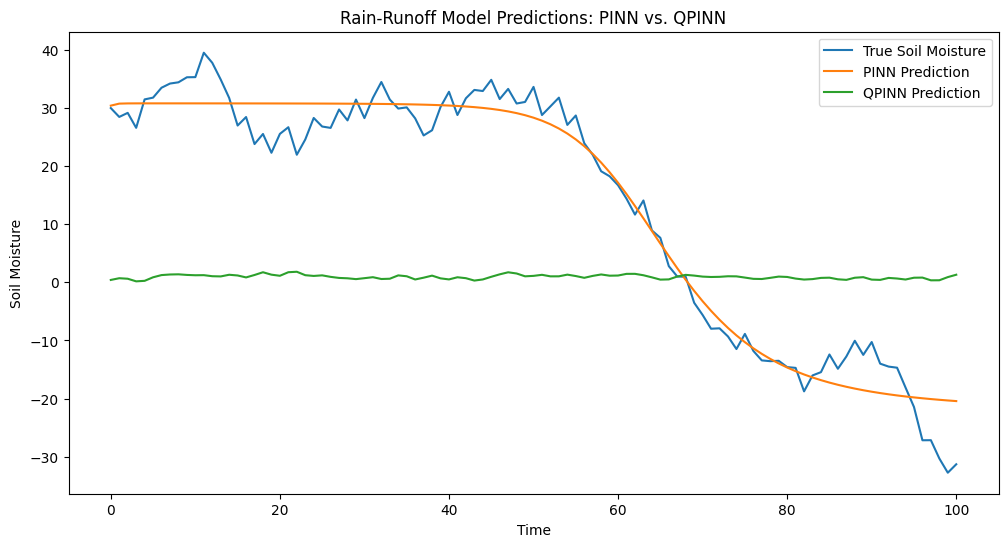

In [10]:


# Evaluate the models
with torch.no_grad():
    predicted_pinn = pinn_model(inputs)
    mse_pinn = criterion(predicted_pinn, targets).item()
    predicted_qpinn = qpinn_model(inputs)
    mse_qpinn = criterion(predicted_qpinn, targets).item()

print(f'PINN - MSE: {mse_pinn:.4f}, Training Time: {pinn_training_time:.2f} seconds')
print(f'QPINN - MSE: {mse_qpinn:.4f}, Training Time: {qpinn_training_time:.2f} seconds')

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(time_steps, soil_moisture, label='True Soil Moisture')
plt.plot(time_steps, predicted_pinn.numpy(), label='PINN Prediction')
plt.plot(time_steps, predicted_qpinn.numpy(), label='QPINN Prediction')
plt.xlabel('Time')
plt.ylabel('Soil Moisture')
plt.legend()
plt.title('Rain-Runoff Model Predictions: PINN vs. QPINN')
plt.show()

# Conclusion
# This project demonstrates the integration of QPINNs with a rain-runoff model and provides a framework for evaluating the performance of QPINNs against classical PINNs. By leveraging quantum computing, we can potentially achieve better accuracy and handle complex, high-dimensional interactions more efficiently. This approach can be extended to more detailed hydrological models and real-world climate data for comprehensive climate change studies.
